<a href="https://colab.research.google.com/github/ML20220207/TFbasics/blob/main/03_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table: Typical architecture of a classification network. Source: Adapted from page 295 of Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron
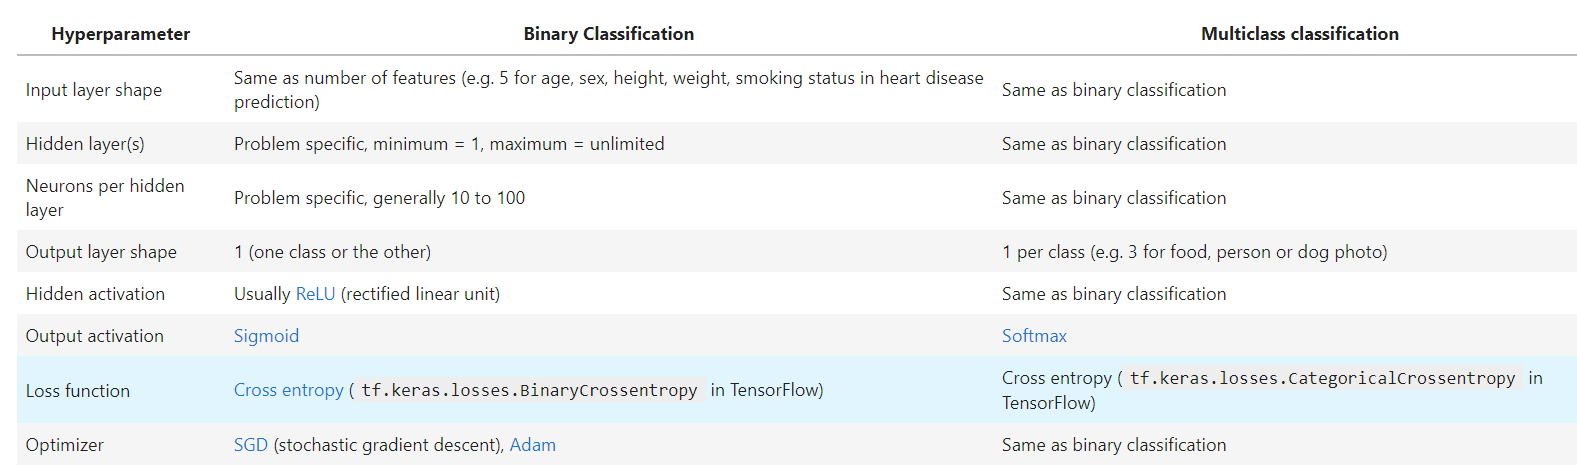

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__) # check the version (should be 2.x+)

2.7.0


# **Working with a larger example (multiclass classification)**



## 1.Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

In [ ]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

In [ ]:
# Check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

In [ ]:
# Check shape of a single example
train_data[0].shape, train_labels[0].shape

In [ ]:
# Plot multiple random images of fashion MNIST
import random
import matplotlib.pyplot as plt
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

In [14]:
# Check the min and max values of the training data
train_data.min(), train_data.max()

(0, 255)

In [15]:
# Divide train and test images by the maximum value (normalize it)
train_data = train_data / 255.0
test_data = test_data / 255.0

## 2.Model

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels))

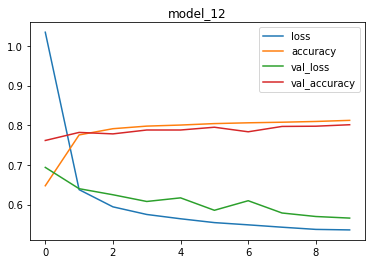

In [18]:
# Plot normalized data loss curves
pd.DataFrame(norm_history.history).plot(title="model_12");


### find the ideal learning rate

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_13 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
find_lr_history = model_13.fit(train_data,
                               train_labels,
                               epochs=40, # model already doing pretty good with current LR, probably don't need 100 epochs
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler])

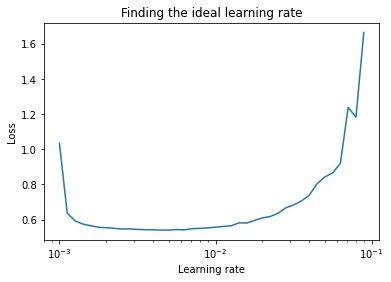

In [20]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, find_lr_history.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

ideal learning rate is 10^(-3).

## 3.visualize its predictions across the different classes

### confusion_matrix

In [27]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [29]:
# Make predictions with the most recent model
y_probs = model_12.predict(test_data) # "probs" is short for probabilities
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels, 
                 y_pred=y_preds)

array([[801,  11,  27,  81,   7,   1,  62,   0,  10,   0],
       [  2, 940,   2,  36,   7,   0,  13,   0,   0,   0],
       [ 34,   2, 662,  14, 166,   1, 108,   0,  13,   0],
       [ 67,  12,  12, 836,  33,   0,  28,   0,  12,   0],
       [  3,   1, 119,  44, 730,   0,  92,   0,   9,   2],
       [  0,   0,   0,   0,   0, 918,   0,  51,   7,  24],
       [205,   9, 171,  58, 141,   3, 397,   0,  16,   0],
       [  0,   0,   0,   0,   0,  44,   0, 921,   0,  35],
       [  3,   2,  34,  23,  10,  13,   7,   5, 901,   2],
       [  0,   0,   2,   0,   4,  37,   0,  47,   2, 908]])

In [ ]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=test_labels, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

### plotting a random image along with its prediction

In [31]:
import random

# Create a function for plotting a random image along with its prediction
def plot_random_image(model, images, true_labels, classes):
  """Picks a random image, plots it and labels it with a predicted and truth label.

  Args:
    model: a trained model (trained on data similar to what's in images).
    images: a set of random images (in tensor form).
    true_labels: array of ground truth labels for images.
    classes: array of class names for images.
  
  Returns:
    A plot of a random image from `images` with a predicted class label from `model`
    as well as the truth class label from `true_labels`.
  """ 
  # Setup random integer
  i = random.randint(0, len(images))
  
  # Create predictions and targets
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28)) # have to reshape to get into right size for model
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  # Plot the target image
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # set the color to green or red

In [ ]:
# Check out a random image as well as its prediction
plot_random_image(model=model_12, 
                  images=test_data, 
                  true_labels=test_labels, 
                  classes=class_names)

## 4.Model structure

In [37]:
# Find the layers of our most recent model
model_12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 3140      
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Get the patterns of a layer in our network
weights, biases = model_12.layers[3].get_weights()

# Shape = 1 weight matrix the size of our input data (28x28) per neuron (4)
weights, weights.shape

(array([[ 0.08677858,  0.70141435, -0.42956913,  0.3560136 , -0.01141049,
         -2.1093943 , -0.10640644, -1.5928134 , -0.21053383, -0.982097  ],
        [-0.39651516, -0.5804805 ,  0.3024611 , -0.8954584 ,  0.43662438,
         -0.04434264,  0.28160992,  0.842002  , -0.5839341 ,  0.87703884],
        [ 0.40030748, -0.85049415,  0.6408207 , -0.32216385, -0.12150378,
          0.55744845,  0.42123955, -1.6476601 , -0.17993791, -0.25138488],
        [-0.5728013 , -0.76989436, -0.36196545,  0.17980005, -0.23396417,
          0.49347678, -0.63278615,  0.3766476 ,  0.74500257,  0.15634345]],
       dtype=float32), (4, 10))

In [46]:
# Shape = 1 bias per neuron (we use 4 neurons in the first layer)
biases, biases.shape

(array([ 0.42644772,  0.90905166, -0.3684488 ,  0.4246419 , -0.84608084,
         1.6361115 ,  0.32391074,  1.0965275 , -1.4117525 , -2.0816216 ],
       dtype=float32), (10,))

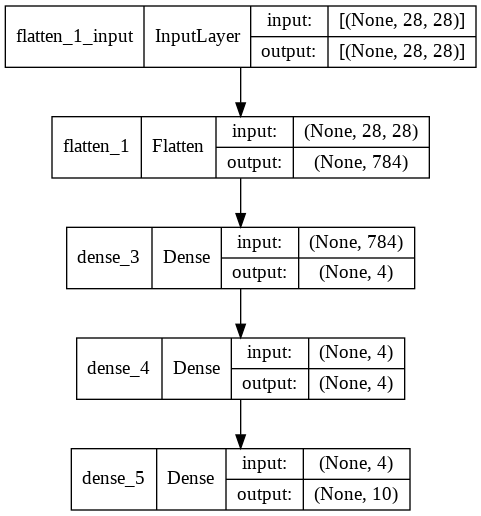

In [47]:
from tensorflow.keras.utils import plot_model

# See the inputs and outputs of each layer
plot_model(model_12, show_shapes=True)

# Binary Classification

## 1.Creating data to view and fit

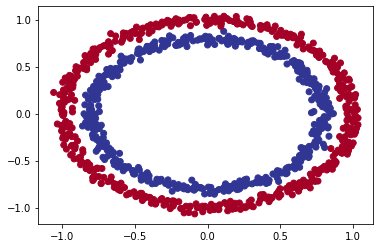

In [48]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## 2.Model

### plot_decision_boundary function

In [49]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

### Model

In [50]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

# Evaluate our model
model_7.evaluate(X, y)

doing binary classifcation...


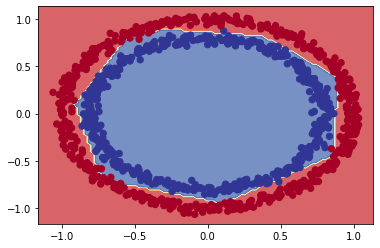

In [52]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)